Use this notebook to begin analysis of MESH to create 'hailstorm' distributions for SPC outlook areas.

Initial Ideas
- Use object identification on 24-hour MESH objects
- Use the number of identified hailstorms to develop probabilities of hailstorm unit area frequency in various SPC outlook categories
- Then develop probability distributions for length of hailstorm swath, width of hailstorm swath, and ~75 percentile of hail size

In [37]:
import gzip
import pygrib as pg
import shutil

In [57]:
import xarray as xr
import matplotlib.pyplot as plt

In [150]:
import skimage
import numpy as np
import scipy.ndimage as ndi

In [28]:
gz_file = './assets/MRMS_MESH_Max_1440min_00.50_20210730-120000.grib2.gz'

In [39]:
f = gzip.open(gz_file, 'rb')

with open('./assets/MRMS-gzip-test.grib2', 'wb') as f_out:
    shutil.copyfileobj(f, f_out)

In [41]:
grbs = pg.open(fname)

In [42]:
grbs.read(1)

[1:34:34 (instant):regular_ll:heightAboveSea:level 500 m:fcst time 0 mins:from 202107301200]

In [44]:
f.close()

### Image Detection

In [58]:
ds = xr.open_dataset('./assets/MRMS-gzip-test.grib2', engine='cfgrib')

In [139]:
x_min = 280
x_max = 285
y_min = 36
y_max = 41

In [140]:
mask_lon = (ds.longitude >= x_min) & (ds.longitude <= x_max)
mask_lat = (ds.latitude >= y_min) & (ds.latitude <= y_max)

In [141]:
cropped_ds = ds.where(mask_lon & mask_lat, drop=True)

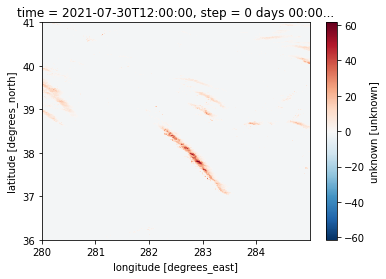

In [142]:
xr.plot.pcolormesh(cropped_ds.unknown,'longitude','latitude')

In [177]:
cropped_mesh = cropped_ds.unknown.values

In [181]:
image = np.zeros_like(cropped_mesh)

# Convert to binary
image[cropped_mesh > 29] = 1

In [182]:
distance = ndi.distance_transform_edt(image)

Text(0.5, 1.0, 'Distances')

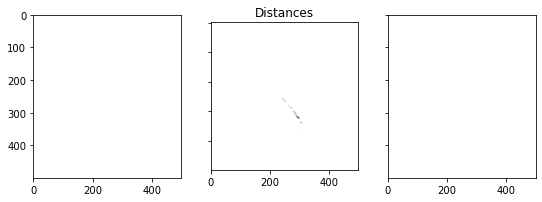

In [183]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')

Generate markers

In [144]:
markers = np.zeros_like(cropped_mesh)
markers[cropped_mesh > 29] = 1

Generate elevation map

In [145]:
from skimage.filters import sobel
from skimage.segmentation import watershed

In [146]:
elevation_map = sobel(cropped_mesh)

In [147]:
segmentation = watershed(elevation_map, markers)